<b>Задание</b>
1. Восстановите пропуски в столбце kitchen_area. 
2. Добавьте информацию из датасета region.csv.
3. Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2.
4. Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.
5. Когда выгодно покупать/продавать объект недвижимости?
6. Создайте модель прогноза цены объекта недвижимости.


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#установим параметры для будущих графиков
custom_params = {"axes.spines.right": False, "axes.spines.top": False,"axes.spines.left":False}
sns.set_theme(style="ticks", palette="pastel",color_codes=True)
plt.rcParams['figure.figsize'] = (8, 6)

In [3]:
#выгрузим датасет
df = pd.read_csv('realty_18_21.csv')
df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...
5477001,19739760,2021-05-01,3,1,8,17,4,93.2,13.8,11
5477002,12503160,2021-05-01,3,2,17,32,2,45.9,6.6,11
5477003,8800000,2021-05-01,2871,2,4,17,3,86.5,11.8,1
5477004,11831910,2021-05-01,3,1,8,33,2,52.1,18.9,11


In [4]:
#уберем отрицательные значения цены
df = df[df['price'] > 0]

In [5]:
#посмотрим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5476618 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 459.6+ MB


In [6]:
#изменим формат даты
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [7]:
#просмотрим, сколько пропусков в нашем датасете
df.isna().sum()

price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     253696
object_type           0
dtype: int64

In [8]:
#добавим столбец с годом
df['year'] = df['date'].dt.year
df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1,2018
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1,2018
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1,2018
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,11,2018
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1,2018
...,...,...,...,...,...,...,...,...,...,...,...
5477001,19739760,2021-05-01,3,1,8,17,4,93.2,13.8,11,2021
5477002,12503160,2021-05-01,3,2,17,32,2,45.9,6.6,11,2021
5477003,8800000,2021-05-01,2871,2,4,17,3,86.5,11.8,1,2021
5477004,11831910,2021-05-01,3,1,8,33,2,52.1,18.9,11,2021


In [9]:
#уберем строки со значениями количества комнат, равными -2
df = df[df['rooms'] > -2]
df['rooms'].unique()

array([ 3,  2,  1,  4, -1,  5,  7,  6,  8,  9, 10], dtype=int64)

In [10]:
#удалим строки, в которых площадь кухни больше общей площади квартиры
df = df[df['area'] > df['kitchen_area']]

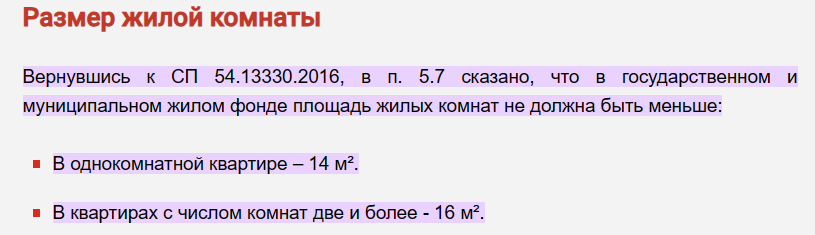

In [11]:
#уберем сначала все значения строк с площадью меньше 14
df = df[df['area'] >= 14]

In [12]:
#отдельно для квартир с 2 и более комнатами установим условие для площади и также отфильтруем наш датасет по нему
condition = (df['area'] < 16) & (df['rooms'] > 1)
df = df.drop(df[condition].index)

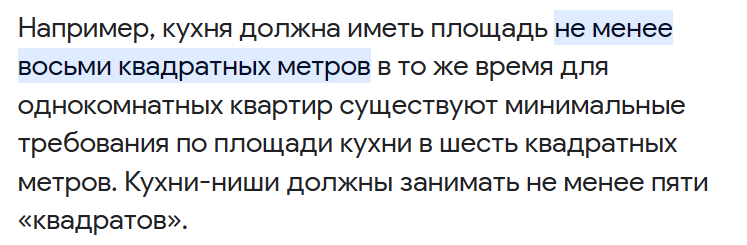

In [13]:
#удалим также строки ,которые не подходят под условия площади кухни
df = df[df['kitchen_area'] >= 6]

In [14]:
condition_2 = (df['kitchen_area'] < 8) & (df['rooms'] > 1)
df = df.drop(df[condition_2].index)
df.shape[0]

4029699

In [59]:
#удалим строки, в которых этаж квартиры больше максимального этажа здания
df = df[df['level'] <= df['levels']]
df.shape[0]

3621522

In [60]:
df.head()

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,reg_name,price_per_square
0,2850000,2019-02-28,9654,0,1,4,-1,45.0,18.0,1,2019,Новосибирская область,63333.333333
1,2850000,2019-02-28,9654,0,1,4,-1,45.0,18.0,1,2019,Новосибирская область,63333.333333
2,6300000,2019-02-28,9654,0,1,17,-1,79.1,26.0,1,2019,Новосибирская область,79646.017699
3,720000,2019-02-28,5282,0,1,3,-1,24.0,20.0,1,2019,Челябинская область,30000.000000
4,960000,2019-02-28,5520,0,1,2,-1,16.0,6.4,1,2019,Пермский край,60000.000000


Вывод:

С помощью удаления строк по СНИПу, строк, в которых площадь кухни больше площади квартиры, и строк, с отрицательным значением цены наш датасет сократился на 1 855 484 стрки.

<div class="alert-info">

    1
</div>

In [15]:
#заполним пропущенные значения в колонке с площадью кухни через коэффициент соотношения площади кухни к общей площади по группам
def missing_value(group):
    group['share_kit_area'] = group['kitchen_area'] / group['area']
    med = group['share_kit_area'].median()
    group['kitchen_area'] = group['kitchen_area'].fillna(group['area'] * med)
    return group
df = df.groupby(['building_type', 'level', 'rooms', 'object_type']).apply(missing_value)

In [16]:
#снова проверим соответствие СНИПу после заполнения
df = df[df['area'] >= 14]
condition = (df['area'] < 16) & (df['rooms'] > 1)
df = df.drop(df[condition].index)
df = df[df['kitchen_area'] >= 6]
condition_2 = (df['kitchen_area'] < 8) & (df['rooms'] > 1)
df = df.drop(df[condition_2].index)
df.shape[0]

4029699

In [17]:
#проверим, есть ли пропуски на данном этапе
df = df.drop(columns = ['share_kit_area'], axis = 1)
df.isna().sum()

price            0
date             0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
year             0
dtype: int64

Вывод:

Мы заполнили пропуски через групповой коэффициент. И можно заметить, что после заполнения количество строк, соответствующих СНИПу не изменился.
Дубликаты было решено не удалять, т.к. квартиры часто имеют однотипную планировку, из чего следует возможное повторение строк.

<div class="alert-info">

    2
</div>

In [18]:
#выгрузим второй датасет с названиями регионов
df2 = pd.read_csv('region.csv')
df2 = df2.rename(columns={'code': 'region'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   region    83 non-null     object
 1   reg_name  83 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [19]:
#при изучении нового датасета было обноружено, что Республика Крым имеет 2 кода региона, которые прописаны через ,
df2[df2['region'] == '7873, 6937'] 

,region,reg_name
36,"7873, 6937",Республика Крым


In [20]:
#добавим отдельных 2 строки с кодом и регионом и удалим строку, которая их объединяет
df2.loc[len(df2.index)] = ['7873', 'Республика Крым']
df2.loc[len(df2.index)] = ['6937', 'Республика Крым']
df2 = df2.loc[df2['region'] != '7873, 6937']

In [21]:
#поменяем тип данных в столбце с кодом региона
df2['region'] = df2['region'].astype('int')

In [22]:
#объединим 2 датафрейма в один на основе кода региона
df = df.merge(df2, on='region', how ='left')

<div class="alert-info">

    3
</div>

In [23]:
#создадим столбец с ценой за м2
df['price_per_square'] = df['price'] / df['area']
df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,reg_name,price_per_square
0,2850000,2019-02-28,9654,0,1,4,-1,45.0,18.0,1,2019,Новосибирская область,63333.333333
1,2850000,2019-02-28,9654,0,1,4,-1,45.0,18.0,1,2019,Новосибирская область,63333.333333
2,6300000,2019-02-28,9654,0,1,17,-1,79.1,26.0,1,2019,Новосибирская область,79646.017699
3,720000,2019-02-28,5282,0,1,3,-1,24.0,20.0,1,2019,Челябинская область,30000.000000
4,960000,2019-02-28,5520,0,1,2,-1,16.0,6.4,1,2019,Пермский край,60000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029694,4504500,2020-12-08,2722,5,27,27,3,68.8,9.7,11,2020,Республика Башкортостан,65472.383721
4029695,10853484,2018-10-03,3,5,28,31,1,45.6,15.1,1,2018,Москва,238015.000000
4029696,11070540,2018-10-03,3,5,29,31,1,45.6,15.1,1,2018,Москва,242775.000000
4029697,11291928,2018-10-03,3,5,30,31,1,45.6,15.1,1,2018,Москва,247630.000000


<Axes: >

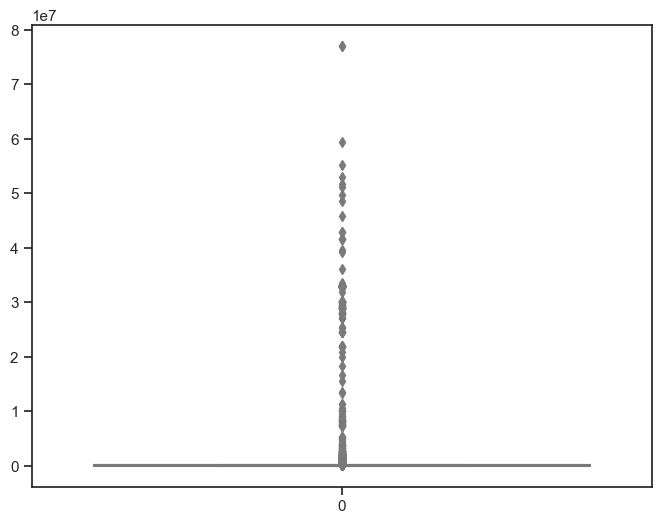

In [24]:
#построим ящик с усами для цены за м2
sns.boxplot(data=df['price_per_square'])

In [41]:
#посчитаем количество выбросов
q75 = np.percentile(df['price_per_square'], 75)
q25 = np.percentile(df['price_per_square'], 25)
iqr = q75 - q25
ejection_h = q75 + iqr*1.5
ejection_l = q25 - iqr*1.5
h_ejection = df['price_per_square'][df['price_per_square'] > ejection_h].count()
l_ejection = df['price_per_square'][df['price_per_square'] < ejection_l].count()
print(f'Число выбросов равно {n_ejection + l_ejection}. Это {(n_ejection*100/df.shape[0]).round()}% от общего числа наблюдений.')

Число выбросов равно 285003. Это 8.0% от общего числа наблюдений.


In [43]:
#удалим выбросы, т.к. 8% - это не критичный процент для нашего исследования
df = df[(df['price_per_square'] <= ejection_h) & (df['price_per_square'] >= ejection_l)].reset_index(drop=True)
df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,reg_name,price_per_square
0,2850000,2019-02-28,9654,0,1,4,-1,45.0,18.0,1,2019,Новосибирская область,63333.333333
1,2850000,2019-02-28,9654,0,1,4,-1,45.0,18.0,1,2019,Новосибирская область,63333.333333
2,6300000,2019-02-28,9654,0,1,17,-1,79.1,26.0,1,2019,Новосибирская область,79646.017699
3,720000,2019-02-28,5282,0,1,3,-1,24.0,20.0,1,2019,Челябинская область,30000.000000
4,960000,2019-02-28,5520,0,1,2,-1,16.0,6.4,1,2019,Пермский край,60000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622483,2375820,2018-10-03,81,5,25,25,1,39.4,10.2,1,2018,Московская область,60300.000000
3622484,2633040,2018-10-03,81,5,25,25,1,42.4,12.1,1,2018,Московская область,62100.000000
3622485,2446740,2018-10-03,81,5,25,25,1,39.4,10.2,1,2018,Московская область,62100.000000
3622486,3242500,2018-10-03,81,5,25,25,2,63.2,11.2,1,2018,Московская область,51305.379747


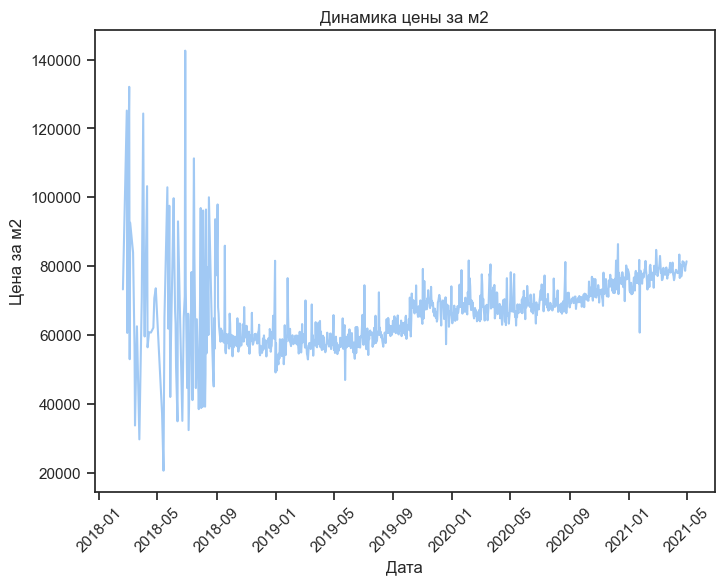

In [70]:
#построим график динамики цены за м2 по датам
sns.lineplot(data=df, x='date', y='price_per_square', errorbar=None, estimator='mean').set(title='Динамика цены за м2', xlabel='Дата', ylabel='Цена за м2')
plt.xticks(rotation=45)
plt.show()

Вывод:

Как видно по графику динамики цены за м2, наиболее сильные колебания были в 2018 году. А далее цена средняя цена потихоньку возрастала с меньшими изменениями.

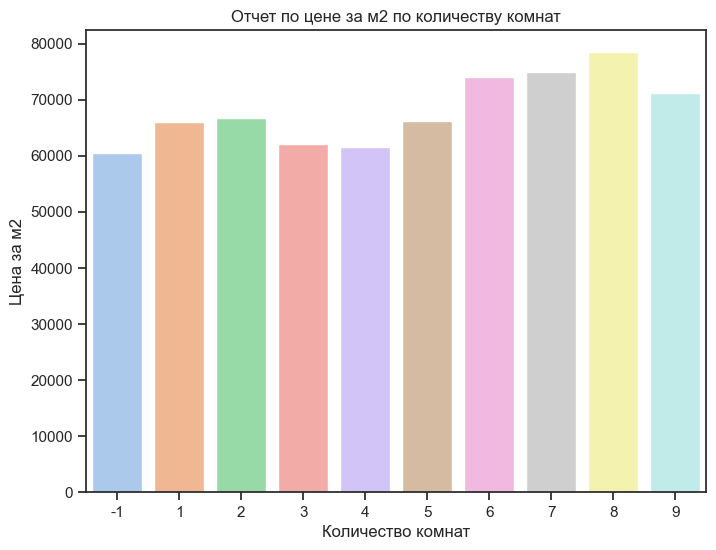

In [45]:
#построим столбчатую диаграмму со средним значением цены за м2 с разбивкой по количеству комнат
rooms_gr = df.groupby('rooms')['price_per_square'].mean().reset_index()
sns.barplot(rooms_gr, x='rooms', y='price_per_square', errorbar=None, estimator=np.mean).set(title='Отчет по цене за м2 по количеству комнат', xlabel='Количество комнат', ylabel='Цена за м2')
plt.show()

Вывод:

Средняя цена за м2 меняется примерно от 60 000 до 80 000. Наибольшую среднюю стоимость можно заметить за квартирами с 8 комнатами, а наименьшую - за студиями.

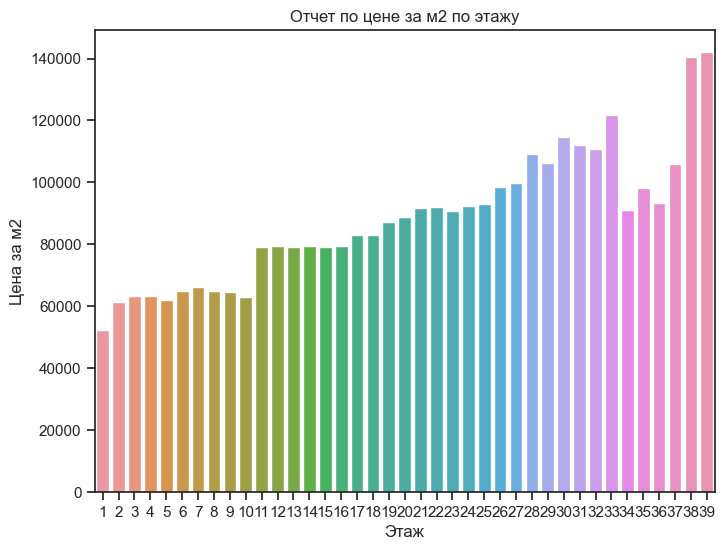

In [86]:
#построим столбчатую диаграмму со средним значением цены за м2 с разбивкой по этажу квартиры
level_gr = df.groupby('level')['price_per_square'].mean().reset_index()
sns.barplot(level_gr, x='level', y='price_per_square', errorbar=None, estimator=np.mean).set(title='Отчет по цене за м2 по этажу', xlabel='Этаж', ylabel='Цена за м2')
plt.show()

Вывод:

В основном тенденция такая: чем выше расположена квартира, тем больше средняя цена за ее м2.  

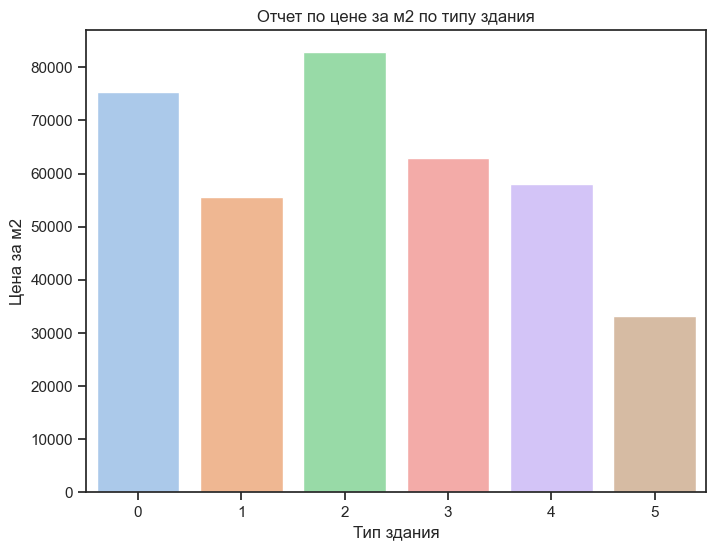

In [47]:
#построим столбчатую диаграмму со средним значением цены за м2 с разбивкой по количеству типу здания
bt_gr = df.groupby('building_type')['price_per_square'].mean().reset_index()
sns.barplot(bt_gr, x='building_type', y='price_per_square', errorbar=None, estimator=np.mean).set(title='Отчет по цене за м2 по типу здания', xlabel='Тип здания', ylabel='Цена за м2')
plt.xticks(rotation=0)
plt.show()

Вывод:

Цена за м2 сильно разнится в зависимости от типа дома, в котором расположена квартира. Например, средняя цена за м2 в деревянном здании более чем в 2 раза меньше средней цены в кирпично-монолитном.

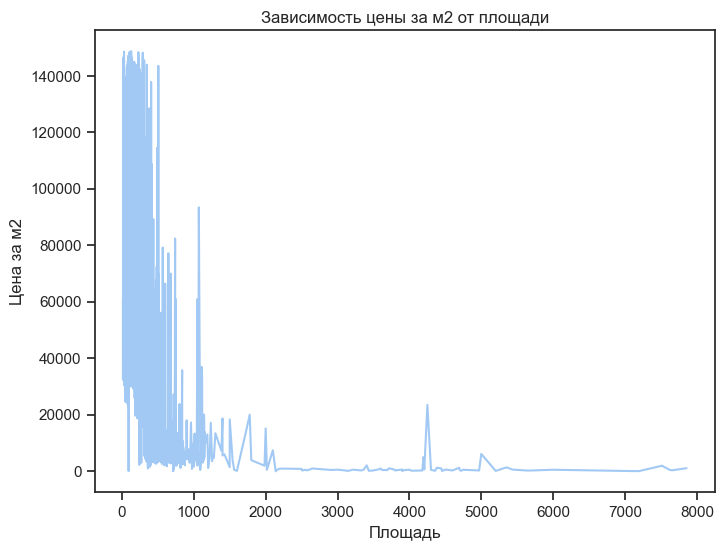

In [87]:
#построим график зависимости цены за м2 от площади квартиры
sns.lineplot(data=df, x='area', y='price_per_square', errorbar=None, estimator='mean').set(title='Зависимость цены за м2 от площади', xlabel='Площадь', ylabel='Цена за м2')
plt.show()

Вывод:

При построении графика "Цена за м2"-"Площадь квартиры" можно заметить, что чем больше площадь квартиры, тем меньше средняя стоимость м2.

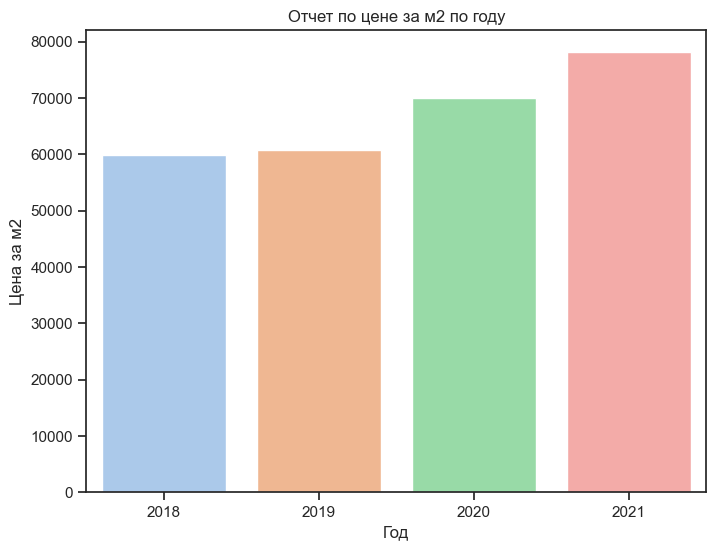

In [49]:
#построим столбчатую диаграмму со средним значением цены за м2 с разбивкой по году
year_gr = df.groupby('year')['price_per_square'].mean().reset_index()
sns.barplot(year_gr, x='year', y='price_per_square', errorbar=None, estimator=np.mean).set(title='Отчет по цене за м2 по году', xlabel='Год', ylabel='Цена за м2')
plt.show()

Вывод:

По столбчатой диаграмме видно, что средняя цена за м2 растет с каждым годом по данным нашего датасета.

<div class="alert-info">

    4
</div>

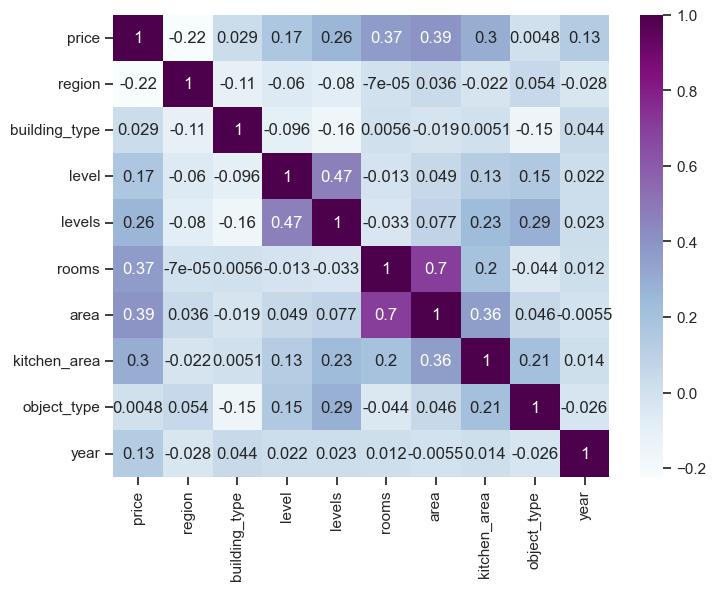

In [61]:
#построим матрицу корреляций для нашего датасета
df_corr = df[['price','region','building_type','level','levels','rooms','area','kitchen_area','object_type','year']]
corr_matrix = df_corr.corr(method='kendall')
sns.heatmap(corr_matrix, annot=True, linecolor='white', cmap="BuPu")
plt.show()

Вывод:

Рассматривая матрицу, можно увидеть, что цена квартиры больше всего коррелирует с количеством этажей в здании, количеством комнат, общей площадью и площадью за м2. И в меньшей степени - с этажом, на котором находится сама квартрира.

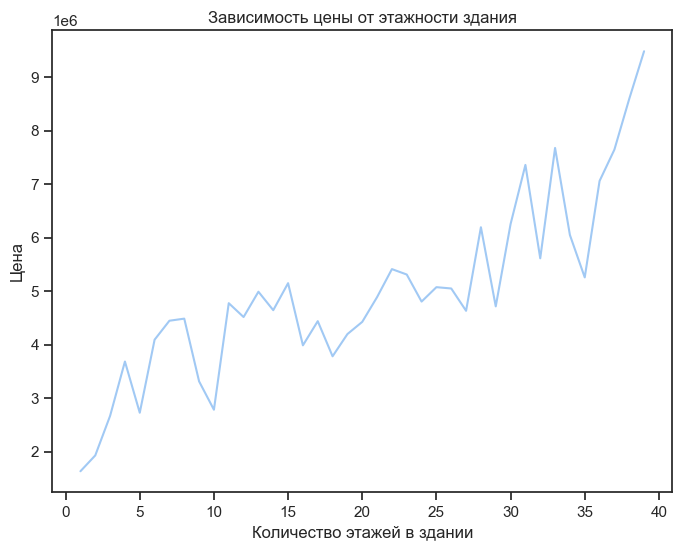

In [77]:
#построим график зависимости цены от этажности здания
sns.lineplot(data=df, x='levels', y='price', errorbar=None, estimator='mean').set(title='Зависимость цены от этажности здания', xlabel='Количество этажей в здании', ylabel='Цена')
plt.show()

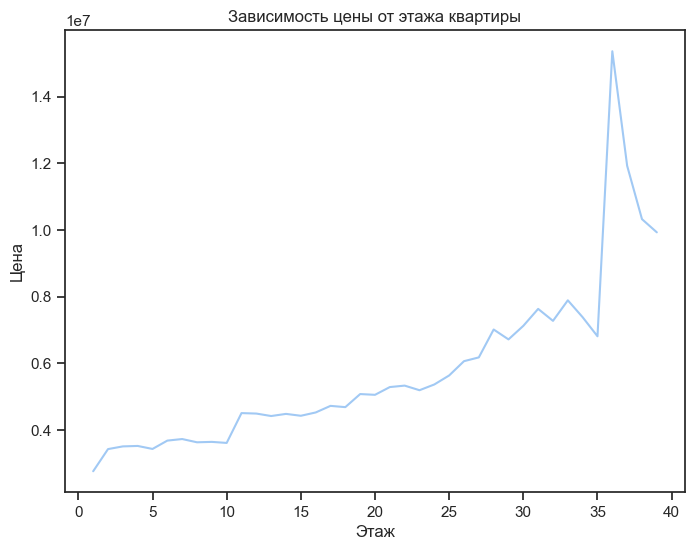

In [78]:
#построим график зависимости цены от этажа квартиры
sns.lineplot(data=df, x='level', y='price', errorbar=None, estimator='mean').set(title='Зависимость цены от этажа квартиры', xlabel='Этаж', ylabel='Цена')
plt.show()

Вывод:

Как можно увидеть, количество этажей в здании и этаж, на котором находится квартира, по графикам довольно-таки напрямую влияет на цену квартиры.

Теперь рассмотрим гипотезы о том, что цена за м2 на первом и последнем этажах отличается от остальных.

H0: средняя цена за м2 на первом и остальных этажах не отличается

H1: средняя цена за м2 на первом этаже ниже, чем на остальных этажах

In [83]:
#проведем тест Манна-Уитни
df_1 = df[df['level'] != 1]
df_2 = df[df['level'] == 1]

sample_1 = df_1['price_per_square'].tolist()
sample_2 = df_2['price_per_square'].tolist()

alpha = 0.05
results = st.mannwhitneyu(sample_1, sample_2)
print('p-value', results.pvalue / 2)

if results.pvalue / 2 < alpha and np.mean(sample_2) < np.mean(sample_1):
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value 0.0
Отклоняем нулевую гипотезу


Следовательно, можно сделать вывод о том, что цена за м2 на первом действительно ниже, чем на других этажах

H0: средняя цена за м2 на последнем и остальных этажах не отличается

H1: средняя цена за м2 на последнем этаже выше, чем на остальных этажах

In [84]:
#проведем тест Манна-Уитни
df_3 = df[df['level'] != df['levels']]
df_4 = df[df['level'] == df['levels']]

sample_1 = df_3['price_per_square'].tolist()
sample_2 = df_4['price_per_square'].tolist()

alpha = 0.05
results = st.mannwhitneyu(sample_1, sample_2)
print('p-value', results.pvalue / 2)

if results.pvalue / 2 < alpha and np.mean(sample_2) < np.mean(sample_1):
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value 0.0
Отклоняем нулевую гипотезу


По полученным результатам мы можем говорить о том, что средняя цена за м2 на последнем этаже выше, чем на остальных этажах.

<div class="alert-info">

    5
</div>

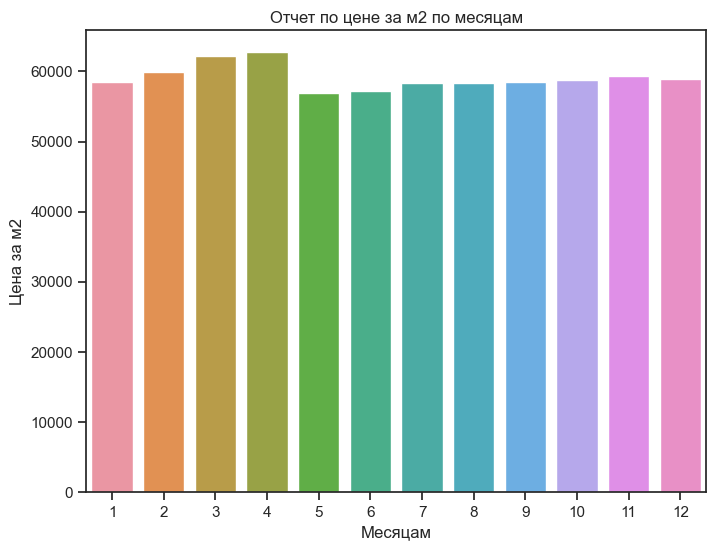

In [101]:
#построим столбчатую диаграмму со медианным значением цены за м2 с разбивкой по месяцу
df['month'] = df['date'].dt.month
month_gr = df.groupby('month')['price_per_square'].median().reset_index()
sns.barplot(month_gr, x='month', y='price_per_square', errorbar=None, estimator=np.median).set(title='Отчет по цене за м2 по месяцам', xlabel='Месяцам', ylabel='Цена за м2')
plt.show()

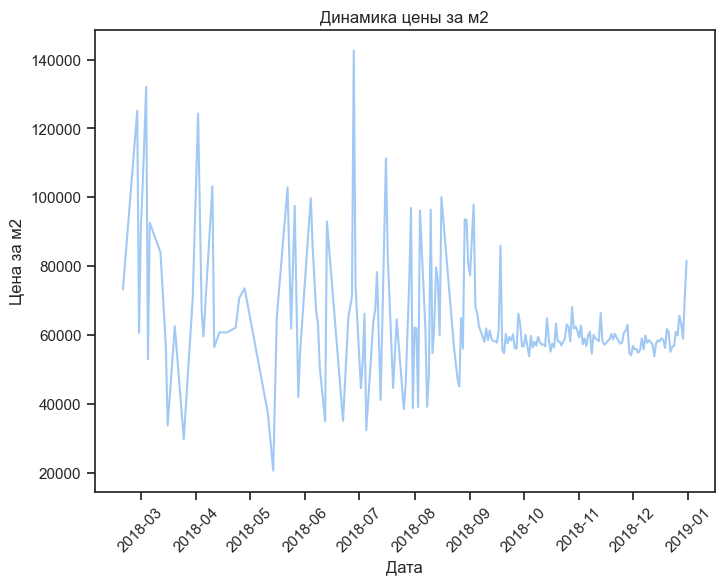

In [97]:
#построим графики динамики цены за м2 по годам
df_2018 = df[df['year'] == 2018]
sns.lineplot(data=df_2018, x='date', y='price_per_square', errorbar=None, estimator='median').set(title='Динамика цены за м2', xlabel='Дата', ylabel='Цена за м2')
plt.xticks(rotation=45)
plt.show()

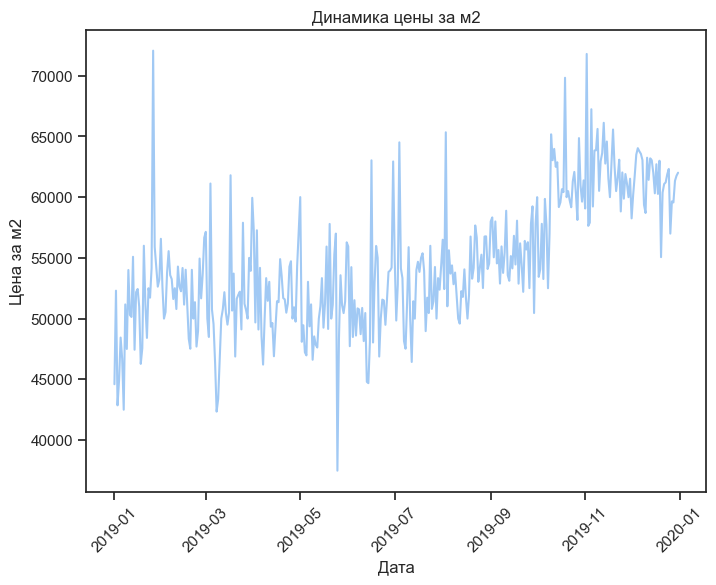

In [102]:
df_2019 = df[df['year'] == 2019]
sns.lineplot(data=df_2019, x='date', y='price_per_square', errorbar=None, estimator='median').set(title='Динамика цены за м2', xlabel='Дата', ylabel='Цена за м2')
plt.xticks(rotation=45)
plt.show()

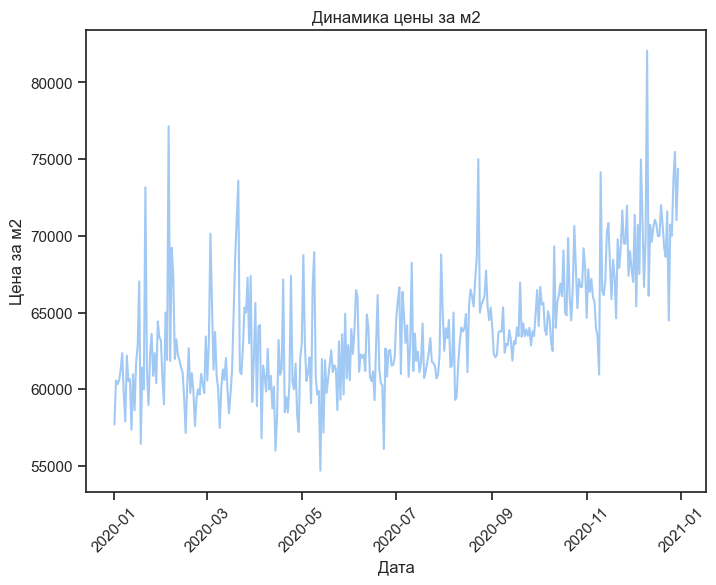

In [103]:
df_2020 = df[df['year'] == 2020]
sns.lineplot(data=df_2020, x='date', y='price_per_square', errorbar=None, estimator='median').set(title='Динамика цены за м2', xlabel='Дата', ylabel='Цена за м2')
plt.xticks(rotation=45)
plt.show()

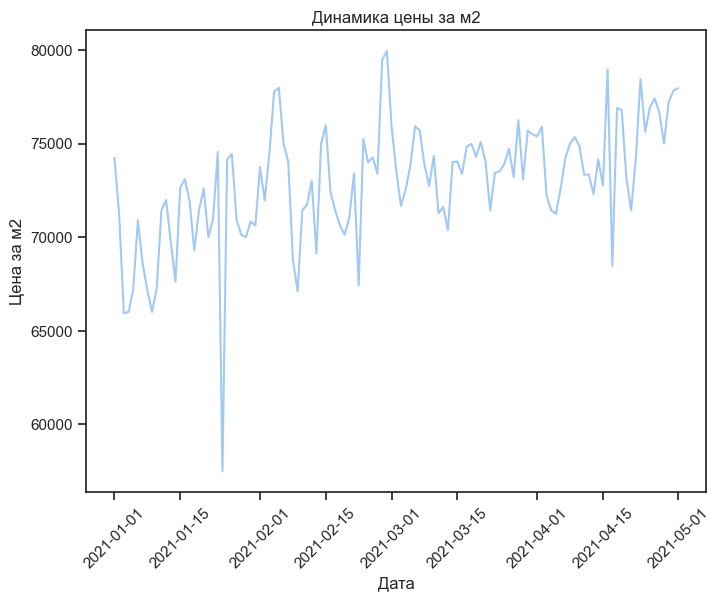

In [104]:
df_2021 = df[df['year'] == 2021]
sns.lineplot(data=df_2021, x='date', y='price_per_square', errorbar=None, estimator='median').set(title='Динамика цены за м2', xlabel='Дата', ylabel='Цена за м2')
plt.xticks(rotation=45)
plt.show()

Вывод:

Самая выгодная цена за м2 квартиры наблюдается в мае (выгодно покупать) и растет до своего максимального медианного значения в апреле (выгодно продавать).

<div class="alert-info">

    6
</div>

In [121]:
#построим модель для предсказания цены на основе линейной регрессии
selected_features = ['level','levels','rooms','area','kitchen_area', 'building_type']
x = df[selected_features]
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
coefficients = model.coef_
inter = model.intercept_

print(coefficients, inter)

[  6303.2241938  104698.2200923  801260.26421456  15151.43449319
  98055.19409204 155687.73289246] -1362798.6156977266


price = -1362798.6156977266 + 6303.2241938 * level + 104698.2200923 * levels + 801260.26421456 * rooms + 15151.43449319 * area + 98055.19409204 * kitchen_area + 155687.73289246 * building_type

In [122]:
y_pred = model.predict(x_test)

In [123]:
r2_score(y_test, y_pred)

0.3388699994130967

33.89% вариации стоиомости квартиры обусловлено вариацией включенных в модель факторов.

In [124]:
r2_score(y_test, y_pred) ** 0.5

0.5821254155361169

По шкале Чеддока связь заметная.

In [125]:
#построим модель для предсказания цены на основе линейной регрессии с фиктивной переменной
selected_features = ['level','levels','rooms','area','kitchen_area', 'building_type', 'object_type']
x = df[selected_features]
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
coefficients = model.coef_
inter = model.intercept_

print(coefficients, inter)

[  5310.35412103 115514.54859036 782109.24096616  15093.4576766
 103561.55015561 129836.9146804  -50858.57739792] -1253145.271455409


price = -1304003.85 + 5310.35412103 * level + 115514.54859036 * levels + 782109.24096616 * rooms + 15093.4576766 * area + 103561.55015561 * kitchen_area + 129836.9146804 * building_type

In [127]:
y_pred = model.predict(x_test)

In [128]:
r2_score(y_test, y_pred)

0.33975074382181447

33.98% вариации стоиомости квартиры обусловлено вариацией включенных в модель факторов.

In [129]:
r2_score(y_test, y_pred) ** 0.5

0.5828814148879808

По шкале Чеддока связь заметная.

In [131]:
#добавим регион в параметры
selected_features = ['level','levels','rooms','area','kitchen_area', 'building_type', 'object_type', 'region']
x = df[selected_features]
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
coefficients = model.coef_
inter = model.intercept_

print(coefficients, inter)

[ 4.17285969e+03  9.89845307e+04  7.57318397e+05  1.61157373e+04
  1.03107009e+05  4.86448639e+04 -3.38785071e+04 -1.49924309e+02] -301744.37282730034


price = -301744.37282730034 - -3.38785071e+04 + 4.17285969e+03 * level + 9.89845307e+04 * levels + 7.57318397e+05 * rooms + 1.61157373e+04 * area + 1.03107009e+05 * kitchen_area + 4.86448639e+04 * building_type - 1.49924309e+02 * region

In [132]:
y_pred = model.predict(x_test)

In [133]:
r2_score(y_test, y_pred)

0.3715223532618491

37.15% вариации стоиомости квартиры обусловлено вариацией включенных в модель факторов.

In [134]:
r2_score(y_test, y_pred) ** 0.5

0.6095263351667827

По шкале Чеддока связь заметная.